In [1]:
%matplotlib inline

# Neural Networks and Learning Machines
## Exercise 5 - Convolutional ANN and Transfer learning

# Introduction
The goal of this exercise is for you to get a better understanding of what convolution is, how it is leveraged to increase the usability and performance of neural networks. The exercise will also teach you about transfer learning and the differences between fine-tuning/feature extraction. 

## Literature
This exercise will rely on the following sections in the [course book](https://www.deeplearningbook.org/).

- Chapter 9
    - Most of it
- Chapter 7
    - Section 7.4 - Dataset augmentation
- Chapter 15
    - Section 15.2 - Transfer learning
    
## Examination
Epochs are predefined to be 30. Feel free to increase/decrease this number depending on the hardware that you are working with. Just make sure that you use the same hyperparameters on tasks 2, 3 and 4. **Make sure you have all examination requirements in order before presenting.**

### Task 1
1. Implementation of same convolution.
2. The resulting image using 3 different filters.

### Task 2
1. The given network trained, validated and tested on the given dataset. Don't forget to make the train/validation/test split of the dataset. This can be achieved programmatically using https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split.
2. Some type of regularization should be used. You should understand how the chosen regularization technique works.
3. Report the training, validation and test accuracy. (Should beat randomly picking)
4. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
5. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 3
1. Fine-tune Resnet18 on the given dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 4
1. Use Resnet18 as a feature extractor on the dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

# Convolution in Neural Networks
A convolutional neural network, CNN for short, is a type of ANN that consists of at least one convolutional layer. CNN's are often used where the input size may vary such as when we are dealing with image input. The architecture of CNNs was inspired by how the visual cortex functions in our brain.

## Task 1: Implement convolution
Implement 2d same convolution without using a built-in convolution function. This should function as described in [this blog post](https://jcbgamboa.github.io/2017/08/12/what-are-convolutions/). One of the great strengths of convolution is that it functions on any sized image, hence it is important that your implementation also does. Same convolution means that the dimensions of the output are the same as the dimensions of the input. This is achieved by padding the input.

Once you have implemented a function that performs 2d convolution, use that to perform convolution over all channels in this image. Show the result using 3 different filters.

To find the padding needed to get the input to be the same space as the output you can use the formula:

$$ n_{out} = \left \lfloor\frac{n_{in}+2p-k}{s} \right \rfloor+1 $$

where $n_{out}$ is the number of output features, $n_{in}$ is the number of input features, $k$ is the kernel size, $p$ is the padding size and $s$ is the stride size. You can assume that the stride is always 1.

In [16]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import os
import copy


epochs = 100
plt.rcParams['figure.figsize'] = [12, 30]
plt.rcParams['figure.dpi'] = 100

# Implement same convolution in the function below (kernel is a 2d numpy array an example of which can be found in the test)
def get_padding(image, kernel, strides=1):
    ''' Get required padding for matching input and output size in 2Dconv.'''
    return int(((image.shape[0] - 1)/strides - image.shape[0] + kernel.shape[0])/2)

def conv(image, kernel, strides=1):
    ''' 2D same convolution between image and kernel.
    Non-default stride not yet tested!
    Padding != 1 not yet tested!
    '''

    # Padding for the matching input size
    pad_value = get_padding(image, kernel, strides)
    padded_image = np.pad(image, pad_value)

    # Convolve
    output = np.zeros(image.shape)
    for row in range(0, image.shape[0], strides):
        for col in range(0, image.shape[1], strides):
            input_slice = padded_image[row:row+kernel.shape[0], col:col+kernel.shape[0]]
            output[row][col] = np.sum(np.multiply(kernel, input_slice))
    
    return output

def get_preds_labels(some_network, some_loader):
    ''' Gets all the labels and predictions for a given data loader.
    '''
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in some_loader:
                images, labels = batch
                preds = some_network(images)
                preds = torch.argmax(preds, dim=1)  # convert to tensor
                preds = preds.cpu().numpy().tolist()  # convert to list
                
                all_preds.extend(preds)
                all_targets.extend(labels.cpu().numpy().tolist())

    return all_targets, all_preds

def get_acc(some_network, some_loader):
    ''' Gets accuracy from a given data loader
    '''
    matches = 0
    samples = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(some_loader):
            preds = some_network(data)

            matches += sum([np.argmax(preds[i]) == labels[i] for i in range(len(preds))])
            samples += len(labels)

    return matches/samples

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Our test, don't edit
inp = np.array([[1,1,1,1],[1,1,2,1],[1,-3,-4,1],[1,1,1,1]])
kernel = np.array([[0,1,0],[1,2,1],[0,1,0]]) # This is the second input of conv()

# If all are TRUE the convolution is implemented correctly
ans = np.array([[4, 5, 6, 4], [5, 3, 3, 6], [1, -7, -7, 0], [4, 1, 0, 4]])
print(conv(inp, kernel) == ans)

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


Mounted at /content/gdrive
Loaded picture!


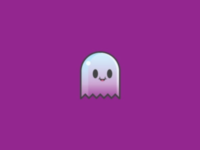

In [3]:
from cv2 import imread
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path =  "/content/gdrive/MyDrive/Colab Notebooks/Neural/ANN3/pinkghost.jpg"

pic = imread(path)
if pic.all() == None:
    print('Couldnt load the pic, check path')
else:
    print('Loaded picture!')
    pic = imread(path)
    pic = cv2.pyrDown(pic)
    cv2_imshow(pic)

#if image.all() == None:
 #   print('Couldnt load pic, check the path')
#else:
 #   print('Loaded picture!')
  #  plt.imshow(image)
   # plt.show()

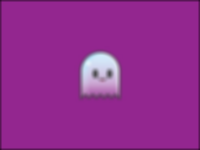

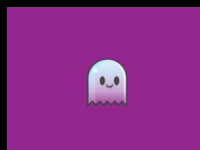

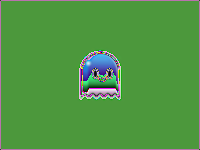

In [4]:
# Blur filter
x = 1/25
kernel_1 = np.array([[x,x,x,x,x],[x,x,x,x,x],[x,x,x,x,x],[x,x,x,x,x],[x,x,x,x,x]])

# Displacement filter
kernel_2 = np.zeros([15,15])
kernel_2[0,0] = 1

# Color overshoot filter
x = 1
kernel_3 = np.array([[0,x,0],[x,0,x],[0,x,0]])


for kernel in [kernel_1, kernel_2, kernel_3]:
    pic_out = pic.copy()
    for i in [0, 1, 2]:
        pic_out[:,:,i] = conv(pic[:,:,i], kernel)
    cv2_imshow(pic_out)

# Computer Vision
Computer vision (CV) is a task within the computer science field that aim is to extract high-level information from static images or video. Such high-level information can be, but is not limited to:
* Object detection - Detect and classify objects within input images
* Anomaly detection - Detect anomalies in the input images
* Semantic segmentation - Classify each pixel in the input image into different classes
* Object recognition - Classifying an entire image depending on what it contains

CV has been studied for multiple decades where early solutions used handwritten feature extractors to extract information from the input. However, with the increase of computing power together with the rise of deep learning algorithms, the main method used to solve CV problems is convolutional neural networks.

In this exercise, we will be taking a closer look at object recognition by first using a randomly initialized network and then utilizing transfer learning. **The dataset we will use for this exercise can be downloaded on canvas**. It is a subset of [this dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). Remember to split the data into separate training, validation and test set.

## Task 2: Implement the missing code and train it on the given dataset.
For task 2, implement the missing parts of the code below. The code should correctly train, validate and test the model. There are some comments guiding you through the process, however if something is unclear try to leverage the documentation for pytorch found [here](https://pytorch.org/docs/stable/index.html). You should also add some type of regularization into your model.

Remember to check the examination requirements in the start of this notebook.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
proj_dir =  "/content/gdrive/MyDrive/Colab Notebooks/Neural/ANN3/dataset"

Mounted at /content/gdrive


In [6]:
# Hyperparams. Set these to reasonable values
BATCH_SIZE = 64
SHUFFLE = True
EPOCHS = 50
LEARNING_RATE = 0.001
INPUT_SIZE = 224

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [8]:
transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.CenterCrop(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the full dataset, perform the training/validation/test split and then load the subsets into dataloaders.
# Remember that the training images should be augmentated.
DATA_DIR = "/content/gdrive/MyDrive/Colab Notebooks/Neural/ANN3/dataset" # Path to dataset

# Load the full dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)


# Split the dataset into train, validation, and test sets
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.15)
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

# train_set    = datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/Neural/ANN3/dataset", transform = transform)
# valid_set    = datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/Neural/ANN3/dataset", transform = transform)
# test_set     = datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/Neural/ANN3/dataset", transform = transform)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=12, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=12, shuffle=True)
# test_loader  = torch.utils.data.DataLoader(test_set, batch_size=14, shuffle=False)

In [9]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    # def __init__(self):
    #     super(Net, self).__init__()
    #     self.conv1 = nn.Conv2d(3, 6, 5)
    #     self.pool = nn.MaxPool2d(2, 2)
    #     self.conv2 = nn.Conv2d(6, 16, 5)
    #     self.fc1 = nn.Linear(16 * 13 * 13, 120)
    #     self.fc2 = nn.Linear(120, 2)
    #     self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


    # def forward(self, x):
    #     x = self.pool(F.relu(self.conv1(x)))
    #     x = self.pool(F.relu(self.conv2(x)))
    #     x = x.view(-1, 16 * 13 * 13)
    #     x = F.relu(self.fc1(x))
    #     x = self.dropout(x)
    #     x = self.fc2(x)
    #     return x
        

# Implement a train model function so you can re_use it in task 3 and 4. 
# Should return the best performing model after training
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    best_val_loss = float('inf')
    best_model = None
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        
        # Train the model
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        # Validate the model
        model.eval()
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
    
    # Load the best model state dictionary
    model.load_state_dict(best_model)
    
    return model

In [10]:
# Load our network
model = Net(num_classes=10)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=EPOCHS, device=device)

# Test the model
tested_model = trained_model.eval()

# Evaluate the model on test set
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = tested_model(images)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.tolist())
    true_labels.extend(labels.tolist())
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test accuracy: {accuracy:.2f}%")

Epoch 1/50, Train Loss: 2.3080, Val Loss: 1.6881
Epoch 2/50, Train Loss: 1.7307, Val Loss: 2.2132
Epoch 3/50, Train Loss: 2.1767, Val Loss: 2.0548
Epoch 4/50, Train Loss: 1.9236, Val Loss: 1.8597
Epoch 5/50, Train Loss: 1.6291, Val Loss: 0.9559
Epoch 6/50, Train Loss: 0.8995, Val Loss: 1.3656
Epoch 7/50, Train Loss: 1.4193, Val Loss: 0.7621
Epoch 8/50, Train Loss: 0.7525, Val Loss: 0.7854
Epoch 9/50, Train Loss: 0.7532, Val Loss: 0.8139
Epoch 10/50, Train Loss: 0.7751, Val Loss: 0.7530
Epoch 11/50, Train Loss: 0.7406, Val Loss: 0.6976
Epoch 12/50, Train Loss: 0.7305, Val Loss: 0.6773
Epoch 13/50, Train Loss: 0.7200, Val Loss: 0.6863
Epoch 14/50, Train Loss: 0.7095, Val Loss: 0.7930
Epoch 15/50, Train Loss: 0.7042, Val Loss: 0.7979
Epoch 16/50, Train Loss: 0.6791, Val Loss: 1.2919
Epoch 17/50, Train Loss: 0.6729, Val Loss: 1.0034
Epoch 18/50, Train Loss: 0.6715, Val Loss: 2.1702
Epoch 19/50, Train Loss: 0.6690, Val Loss: 0.8404
Epoch 20/50, Train Loss: 0.8002, Val Loss: 0.7620
Epoch 21/

# Transfer learning
Transfer learning refers to the practice to use a model which has already been pre-trained on a large dataset to be able to solve task $T_1$, replace the output layer or a few of the upper layers within this model and retrain the model on a smaller dataset to be able to solve task $T_2$. Formally this can be described as the following:

__Def 1:__ Let $D_s$ be the source domain and $T_s$ be the corresponding source task. Let $D_t$ be the target domain and $T_t$ be the corresponding target task. Let $f_t$ be the predictive function for $T_s$. Thus transfer learning aims to improve the learning of $f_t$ in $D_t$ using the already learned knowledge in $D_s$ and $T_s$ where $D_s \neq D_t$ and $T_s \neq T_t$.

The benefit from using transfer learning is that we can train an accurate computer vision model with relatively small amounts of data and computing resources compared to the costly pretraining process of the full convolutional neural network (a few days using multiple GPUs). 

## Fine-tuning and Feature extraction
There are two main ideas when it comes to transfer learning, fine-tuning and feature extraction. When using fine-tuning we allow all weights to be changed during the training phase. However, when we use the pre-trained model as a feature extractor we instead freeze earlier layers of the model, which means that the weights in those layers will not be updated during the training phase and we only update the weights in the upper layers that we have replaced. 

This works because low-level information extracted from the input image is universal between tasks, examples of such information is edge detection, shape detection and pattern detection. This is what the early layers are optimized to do, where later layers extract more abstract features relevant for the task. 

Most of the pre-trained models in PyTorch are trained on [ImageNet](http://www.image-net.org/). 

In this exercise, we use ResNet18 as our model. You should make yourself familiar with the Resnet18 architecture using, for example, [the paper](https://arxiv.org/abs/1512.03385).

## Task 3: Fine-tuning
In task 3 you should fine-tune Resnet18 to the small dataset which is provided above. Some code has been given to you. Remember to re-use functions (such as trained_model) from task 2 to decrease the implementation time.

Remember to check the examination requirements at the start of this notebook.

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1/100, Train Loss: 0.9633, Val Loss: 0.9844
Epoch 2/100, Train Loss: 0.2902, Val Loss: 1.1588
Epoch 3/100, Train Loss: 0.0889, Val Loss: 1.7868
Epoch 4/100, Train Loss: 0.0083, Val Loss: 1.8136
Epoch 5/100, Train Loss: 0.0054, Val Loss: 1.7059
Epoch 6/100, Train Loss: 0.0016, Val Loss: 1.5392
Epoch 7/100, Train Loss: 0.0012, Val Loss: 1.3700
Epoch 8/100, Train Loss: 0.0021, Val Loss: 1.2882
Epoch 9/100, Train Loss: 0.0011, Val Loss: 1.2293
Epoch 10/100, Train Loss: 0.0010, Val Loss: 1.1774
Epoch 11/100, Train Loss: 0.0006, Val Loss: 1.1192
Epoch 12/100, Train Loss: 0.0004, Val Loss: 1.0689
Epoch 13/100, Train Loss: 0.0003, Val Loss: 1.0228
Epoch 14/100, Train Loss: 0.0002, Val Loss: 0.9996
Epoch 15/100, Train Loss: 0.0002, Val Loss: 1.0058
Epoch 16/100, Train Loss: 0.0002, Val Loss: 1.0281
Epoch 17/100, Train Loss: 0.0002, Val Loss: 1.0631
Epoch 18/100, Train Loss: 0.0002, Val Loss: 1.1121
Epoch 19/100, Train Loss: 0.0001, Val Loss: 1.1712
Epoch 20/100, Train Loss: 0.0001, Val Lo

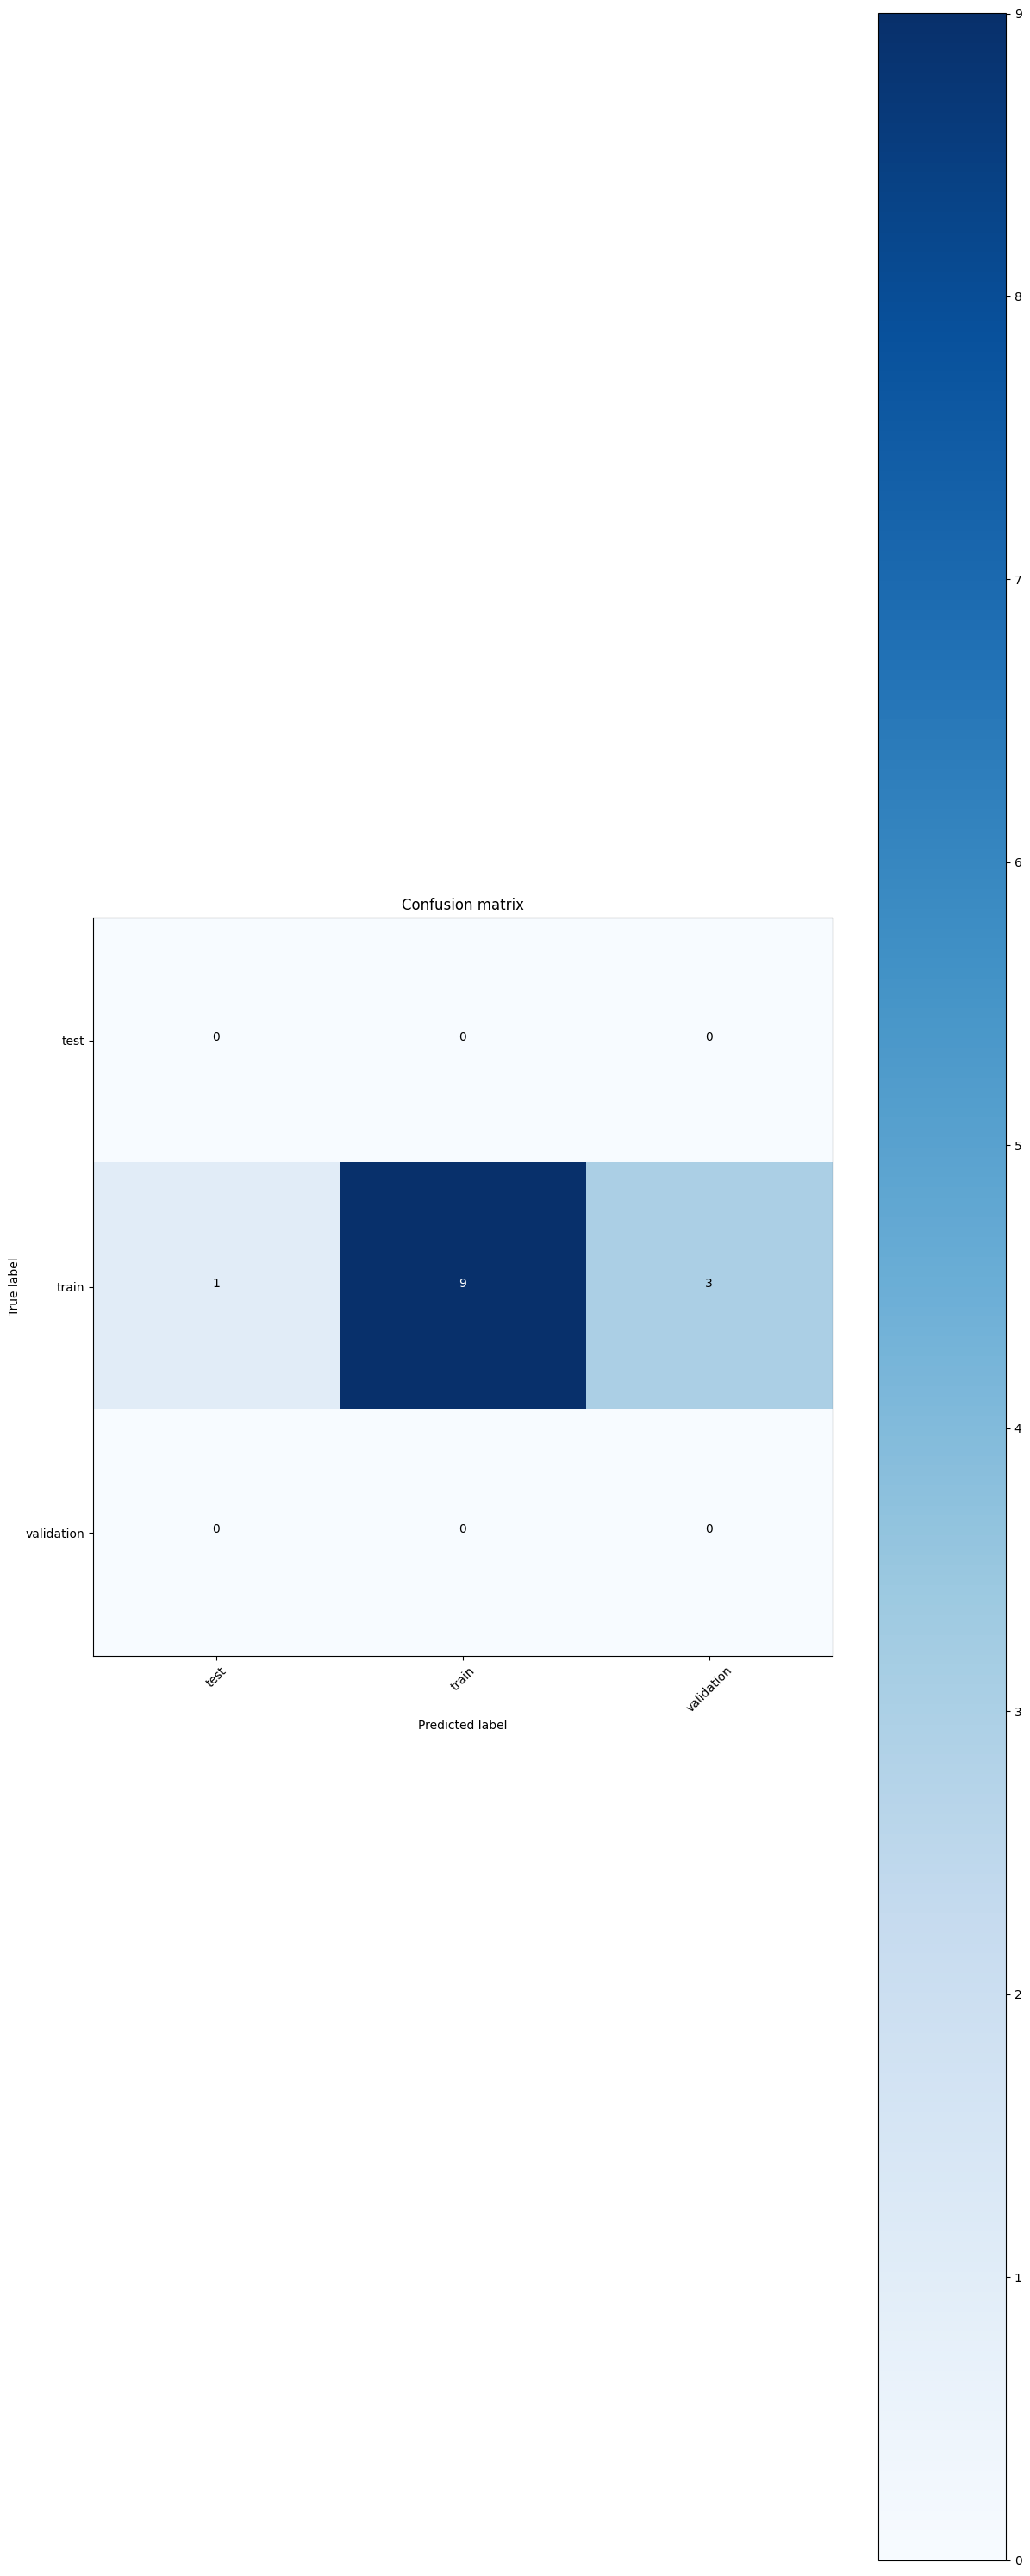

In [11]:
# Fine-tune a model to the dataset

# Define transforms for data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# We use resnet18 as the model.
model_ft = models.resnet18(pretrained=True)

# Do the things required for fine-tuning before training the model
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(dataset.classes))
model_ft = model_ft.to(device)

criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

# Train the model
trained_model_ft = train_model(model_ft, criterion_ft, optimizer_ft, train_loader, val_loader, epochs, device)

# Test the model
tested_model_ft = trained_model_ft.eval() 

# Calculate accuracy on train, val, and test sets
train_acc = get_acc(trained_model_ft, train_loader)
val_acc = get_acc(trained_model_ft, val_loader)
test_acc = get_acc(tested_model_ft, test_loader)
print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# Calculate and plot confusion matrix on test set
test_preds, test_labels = get_preds_labels(trained_model_ft, test_loader)
test_cm = confusion_matrix(test_labels, test_preds, labels=list(range(len(dataset.classes))))
plot_confusion_matrix(test_cm, dataset.classes)

## Task 4: Feature extraction
In task 4, you should use Resnet18 as a feature extractor. Similarly to task 3, some code has been provided. Remember to re-use as much code as you can. 

Once again, check the examination requirements so you don't forget to implement some required functionality.

Epoch 1/10, Training Loss: 6.5907, Training Acc: 0.0000, Validation Loss: 6.3996, Validation Acc: 0.0000
Epoch 2/10, Training Loss: 5.6178, Training Acc: 0.0566, Validation Loss: 6.4275, Validation Acc: 0.0000
Epoch 3/10, Training Loss: 5.1930, Training Acc: 0.2642, Validation Loss: 6.4364, Validation Acc: 0.0000
Epoch 4/10, Training Loss: 4.9080, Training Acc: 0.5094, Validation Loss: 7.4474, Validation Acc: 0.0000
Epoch 5/10, Training Loss: 4.6500, Training Acc: 0.6604, Validation Loss: 8.5653, Validation Acc: 0.0000
Epoch 6/10, Training Loss: 4.4130, Training Acc: 0.7547, Validation Loss: 10.5721, Validation Acc: 0.0909
Epoch 7/10, Training Loss: 4.2553, Training Acc: 0.7925, Validation Loss: 9.8383, Validation Acc: 0.0909
Epoch 8/10, Training Loss: 4.2550, Training Acc: 0.7925, Validation Loss: 14.2432, Validation Acc: 0.0000
Epoch 9/10, Training Loss: 4.5986, Training Acc: 0.8113, Validation Loss: 10.6650, Validation Acc: 0.0909
Epoch 10/10, Training Loss: 4.2780, Training Acc: 0.

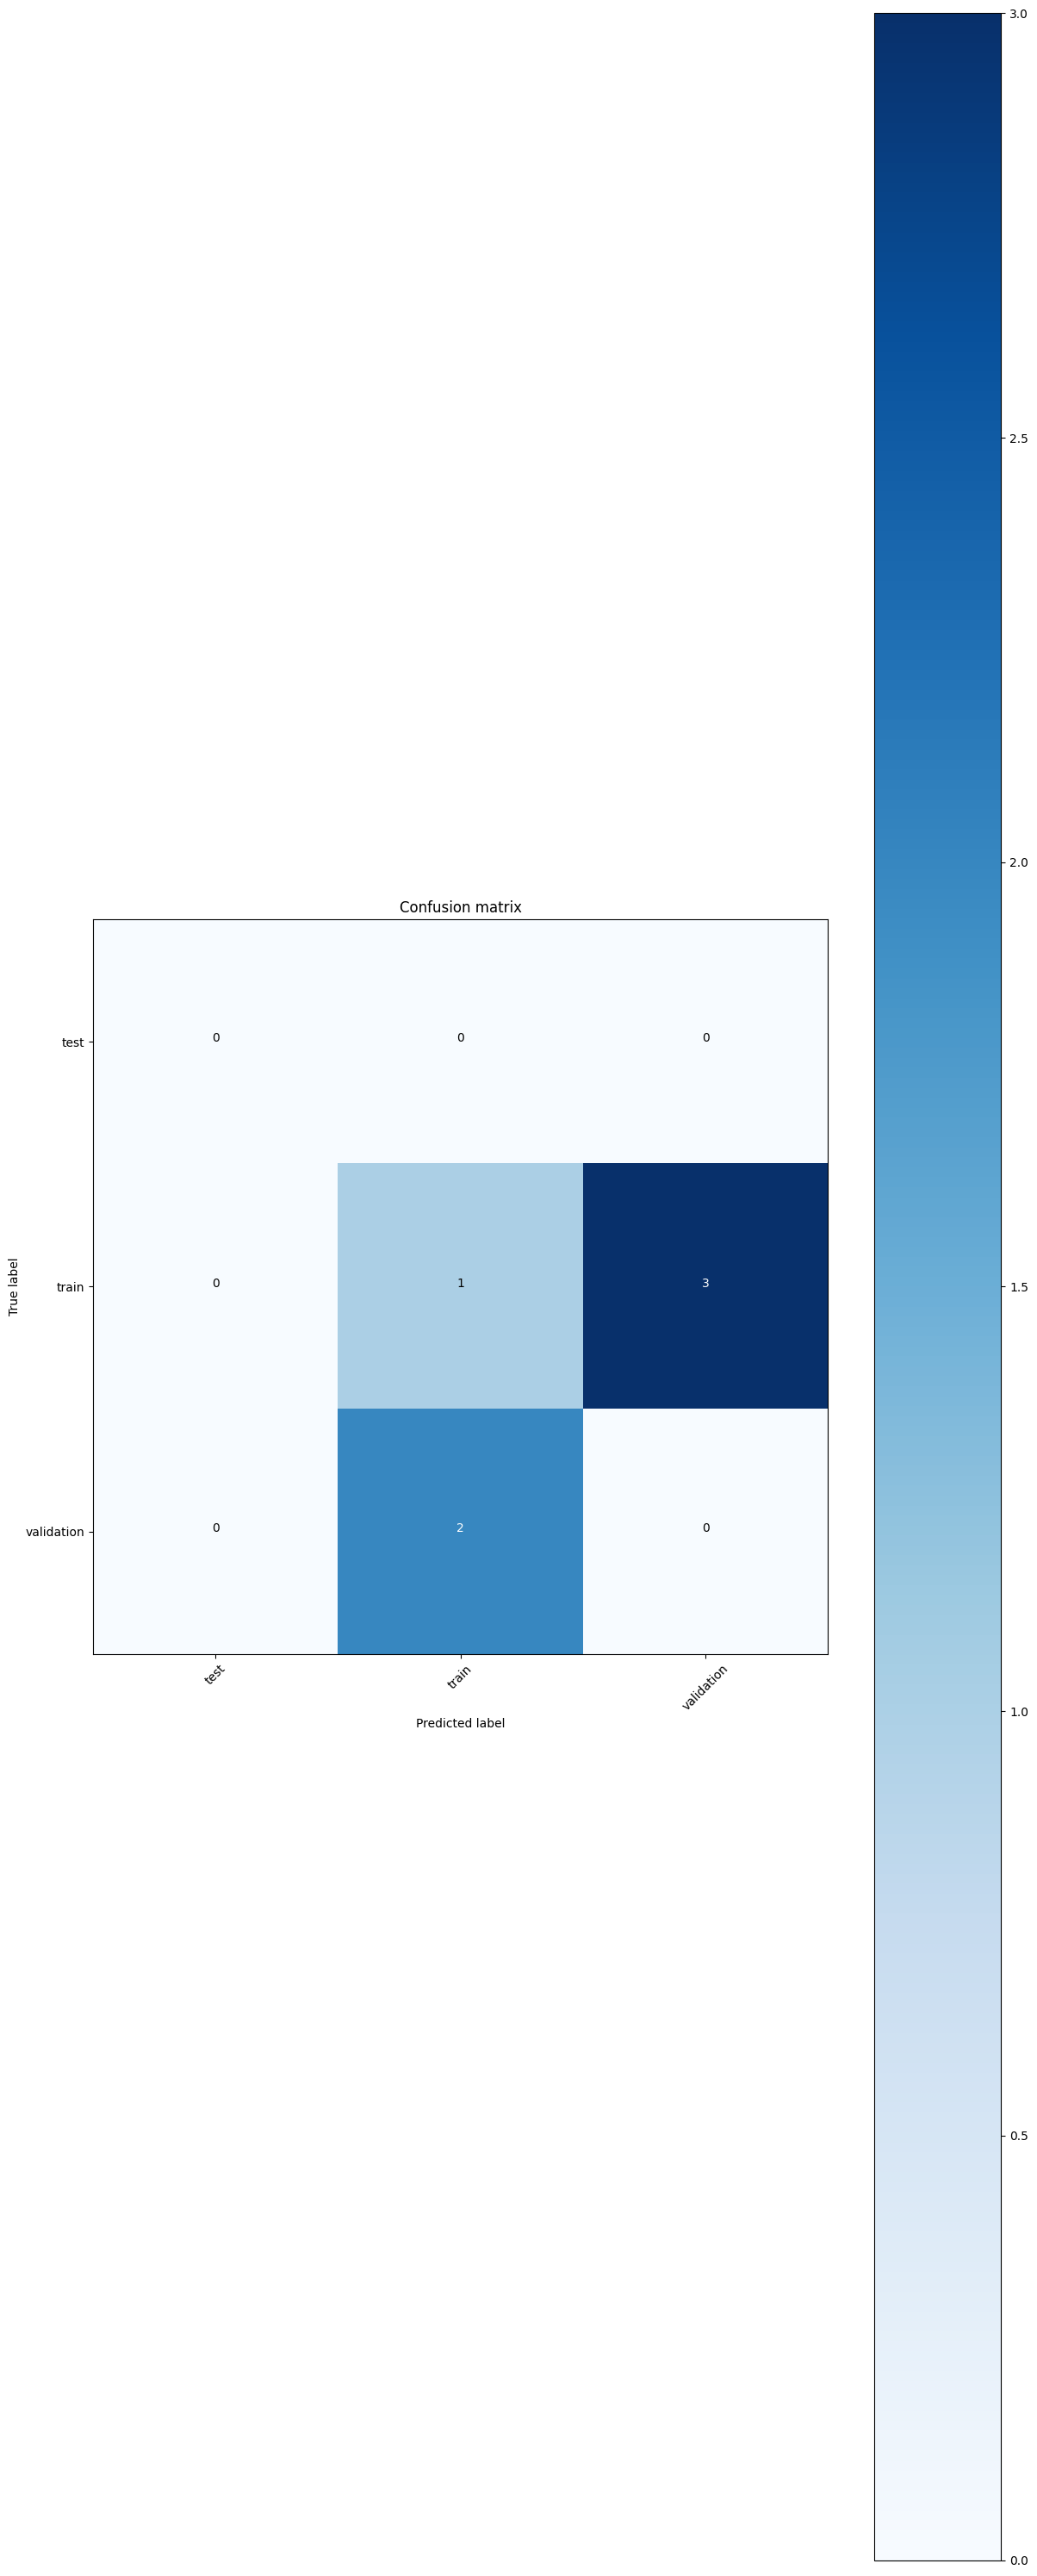

In [39]:
# Use a predefined model as a feature extractor

def get_acc_rn(some_network, some_loader):
    ''' Gets accuracy from a given data loader
    '''
    matches = 0
    samples = 0
    with torch.no_grad():
        for data, labels in some_loader:
            preds = some_network(data)

            matches += sum([np.array(torch.argmax(preds[i].cpu())) == labels[i].cpu().numpy() for i in range(len(preds))])
            samples += len(labels)

    return matches/samples

def train_model_rn(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    # Move the model to the device
    model.to(device)

    # Keep track of the best validation accuracy
    best_val_acc = 0.0

    # Loop over the epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and correct predictions
        running_loss = 0.0
        correct_preds = 0

        # Loop over the training batches
        for images, labels in train_loader:
            # Move the data to the device
            images = images.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Update the running loss and correct predictions
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_preds += torch.sum(preds == labels).item()

        # Calculate the training loss and accuracy
        train_loss = running_loss / len(train_loader.dataset)
        # train_acc = correct_preds.double() / len(train_loader.dataset)
        train_acc = float(correct_preds) / len(train_loader.dataset)

        # Set the model to eval mode
        model.eval()

        # Initialize the running loss and correct predictions
        running_loss = 0.0
        correct_preds = 0

        # Disable gradient computation
        with torch.no_grad():
            # Loop over the validation batches
            for images, labels in val_loader:
                # Move the data to the device
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Update the running loss and correct predictions
                running_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct_preds += torch.sum(preds == labels).item()

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = float(correct_preds) / len(val_loader.dataset)

        # Print the epoch and loss/accuracy information
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

        # Check if this is the best validation accuracy so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            # Save the model
            torch.save(model.state_dict(), 'best_model.pth')

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))

    return model

# We use resnet18 as the model.
model_fe = models.resnet18(pretrained=True)

# Do the things required for fine-tuning before training the model
for param in model_fe.parameters():
    param.requires_grad = True
model_fe.fc = torch.nn.Identity()
for param in model_fe.fc.parameters(): # Add a check to make sure that the fc layer is frozen
    param.requires_grad = False

# Move the model to the device
model_fe.to(device)

# Define the criterion, optimizer and number of epochs
criterion_fe = torch.nn.CrossEntropyLoss()
optimizer_fe = torch.optim.Adam(model_fe.parameters(), lr=LEARNING_RATE)
epochs = 10

# Train the model
trained_model_fe = train_model_rn(model_fe, criterion_fe, optimizer_fe, train_loader, val_loader, epochs, device)

# Test the model
tested_model_fe = trained_model_fe.eval() 

# Calculate accuracy on train, val, and test sets
train_acc = get_acc_rn(tested_model_fe, train_loader)
val_acc = get_acc_rn(tested_model_fe, val_loader)
test_acc = get_acc_rn(tested_model_fe, test_loader)
print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# Calculate and plot confusion matrix on test set
test_preds, test_labels = get_preds_labels(tested_model_fe, test_loader)
test_cm = confusion_matrix(test_labels, test_preds, labels=list(range(len(dataset.classes))))
plot_confusion_matrix(test_cm, dataset.classes)